In [47]:
import pandas as pd
import numpy as np

file_path = "Data/out/202402171421.json"

def read_json(file_path):
    return pd.read_json(file_path, lines=True, dtype={"Timestamp": int})

def hex_to_int(n):
    return int(hex(n)[-7:])

def preprocess(df):
    # Convert "timestamp" column to hexadecimal values
    df["Timestamp_hex"] = df["Timestamp"].apply(lambda x: hex(x))
    df["Timestamp"] = df["Timestamp"].apply(hex_to_int)
    
    df_measures = df[df['Type'] == 2][['Timestamp', 'Measure']]
    df_frequencies = df[df['Type'] == 3][['Timestamp', 'Frequency']]
    df_m = pd.merge(df_measures, df_frequencies, on="Timestamp", how="inner")

    df_measures = df_m.drop(columns=['Frequency'])
    df_frequencies = df_m.drop(columns=['Measure'])

    df_measures = df_measures.explode('Measure')
    df_frequencies = df_frequencies.explode('Frequency')

    df_m = df_measures
    df_m['Frequency'] = df_frequencies['Frequency']

    return df_m

df = read_json(file_path)
df_m = preprocess(df)

df.head(5)


,Checksum,Type,Encrypted,Reserved,Timestamp,Start,End,RBW,Scale,Trigger,Duration,Offset,Points,Slot,Band,Trace,Measure,Frequency,Timestamp_hex
0,254,2,False,0,1000164,700000000.0,960000000.0,300000,-5.000000e+01,15,222.0,0,450,0,16,0.0,"[0.7488098, 3.7080078, 6.1984634, 0.68891144, ...",NaN,0x2402171421000164
1,216,3,False,0,1000578,NaN,NaN,300000,2.539322e-29,15,NaN,0,450,0,0,NaN,NaN,"[700000000, 700579065, 701158129, 701737194, 7...",0x2402171421000578
2,160,2,False,0,1000578,700000000.0,960000000.0,300000,-5.000000e+01,15,231.0,0,450,0,16,0.0,"[-0.79577637, 6.1642914, 3.6556167999999998, 4...",NaN,0x2402171421000578
3,38,3,False,0,1000976,NaN,NaN,300000,2.539322e-29,15,NaN,0,450,0,0,NaN,NaN,"[700000000, 700579065, 701158129, 701737194, 7...",0x2402171421000976
4,147,2,False,0,1000976,700000000.0,960000000.0,300000,-5.000000e+01,15,224.0,0,450,0,16,0.0,"[1.6611023, 6.1212845, 3.6127089999999997, 3.6...",NaN,0x2402171421000976


In [48]:
print("Total rows:", df.shape[0], "Types:", np.unique(df['Type']).shape[0])
diffs = df[df['Type'] == 2]['Timestamp'].diff().dropna()

# Find the index of the row with the largest difference
max_difference_index = diffs.idxmax()
df[max_difference_index-3:max_difference_index+3]

print(np.unique(diffs, return_counts=True))
print(np.unique(df['Timestamp']).shape[0])

Total rows: 127 Types: 2
(array([ 390.,  391.,  394.,  395.,  398.,  399.,  403.,  406.,  414.,
       9391., 9394., 9395., 9398., 9399., 9403., 9406.]), array([ 2,  4, 12,  8,  5,  2,  2,  2,  1,  3,  7,  8,  2,  3,  1,  1]))
64


In [49]:
df_m.head(5)

,Timestamp,Measure,Frequency
0,1000578,-0.795776,700000000
0,1000578,6.164291,700579065
0,1000578,3.655617,701158129
0,1000578,4.146935,701737194
0,1000578,7.638252,702316258


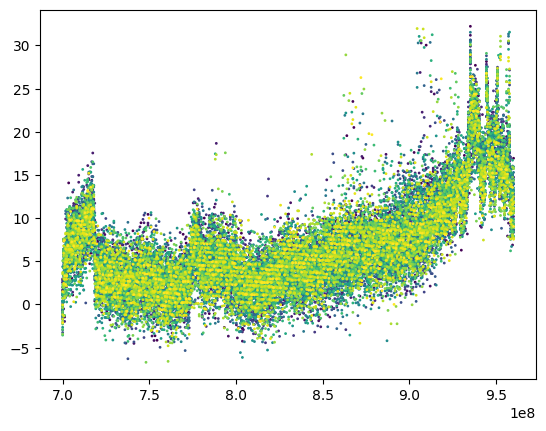

In [50]:
import matplotlib.pyplot as plt

plt.scatter(df_m['Frequency'], df_m['Measure'], c=df_m['Timestamp'], s=1)
plt.show()


In [52]:
import os

folder_path = 'Data/out'

files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) & f.endswith('.json')]

for i, file in enumerate(files, start=1):
    df = read_json(os.path.join(folder_path, file))
    df_m = preprocess(df)
    plt.scatter(df_m['Frequency'], df_m['Measure'], c=df_m['Timestamp'], s=1)
    plt.savefig(f'Plots/{file}.png')
    plt.clf()


KeyError: 'Timestamp'

<Figure size 640x480 with 0 Axes>

/var/folders/yn/16crnc792zg2yr78zf0qg0j40000gq/T/ipykernel_78064/3906823402.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(df_m['Frequency'].iloc[0], y = df_m['Measure'].iloc[0], cmap='viridis', alpha=1, s=2)


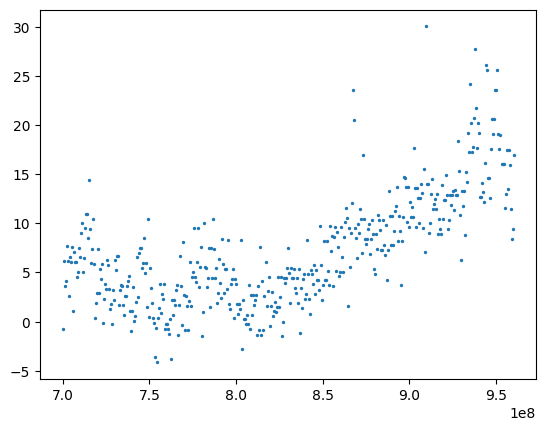

In [46]:
import matplotlib.animation as animation

df = read_json(file_path)

df_measures = df[df['Type'] == 2][['Timestamp', 'Measure']]
df_frequencies = df[df['Type'] == 3][['Timestamp', 'Frequency']]
df_m = pd.merge(df_measures, df_frequencies, on="Timestamp", how="inner")

fig, ax = plt.subplots()
sc = ax.scatter(df_m['Frequency'].iloc[0], y = df_m['Measure'].iloc[0], cmap='viridis', alpha=1, s=2)

def update(frame):
    # Update data for each frame
    x = df_m['Frequency'].iloc[frame]
    y = df_m['Measure'].iloc[frame]
    # colors = np.random.rand(50)
    # sizes = 100 * np.random.rand(50)

    # Update scatter plot data
    sc.set_offsets(np.c_[x, y])
    # sc.set_array(colors)
    # sc.set_sizes(sizes)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=df_m.shape[0], interval=5000)

# Show the plot
plt.show()

# Save animation
ani.save('animation.gif', writer='imagemagick', fps=30)